# Preprocessing

Data exploration of ADNI patients. This notebooks merges all available information extracted from ADNI database and ensures data is ready for further processing.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kruskal

np.random.seed(0)

### Data merging

In [2]:
def process_df(phase):
    # Load data
    df_features = pd.read_table('../DATA/processed_data_adni%d.tsv'%phase, sep=' ').dropna()
    df_patient_list = pd.read_table('../DATA/participants_adni%d.tsv'%phase, names=['Subject', 'PTID'])
    df_metadata = pd.read_csv('../DATA/adni%d_mri.csv'%phase, index_col=0)
    df_conversors = pd.read_csv('../DATA/adni%d_conversors.csv'%phase, index_col=0)
    
    # Combine left and right structures to single structure
    structures = ['Thalmus', 'Caudate', 'Putamen', 'Palidum', 
            'Hippo', 'Amygdala', 'Accumbens']
    for s in structures:
        df_features[s] = df_features['L_%s'%s]+df_features['R_%s'%s]
    
    df_full = df_patient_list.merge(df_features, on='Subject')\
                             .merge(df_metadata, on='PTID')\
                             .merge(df_conversors, on='RID')
    
    # Get back non-normalized (raw features) and rename
    for f in ['Brain_norm', 'GM_norm', 'WM_norm',
        'vscf_norm', 'pgrey_norm']:
        df_full[f] = df_full[f]/df_full['Vscale']
    df_full.rename(columns={'Brain_norm':'Brain_size', 'GM_norm': 'GM', 
                            'WM_norm':'WM', 'vscf_norm':'vscf', 'pgrey_norm':'pgrey'}, inplace=True)

    # Change gender and phase assigment
    df_full['PTGENDER'].replace(['Female','Male'],[0,1],inplace=True)
    df_full['Phase'].replace(['ADNI2','ADNI3'],[0,1],inplace=True)
    
    # Remove any row with nans
    df_full = df_full.dropna()

    return df_full

# Create dataframes for each phase
df_full_adni2 = process_df(2)
df_full_adni3 = process_df(3)

# Concatenate dataframes
pd.set_option('display.max_columns', None)
df_full = pd.concat([df_full_adni2, df_full_adni3], ignore_index=True)
df_full = df_full.drop_duplicates('RID', keep='first') # keep ADNI2 if duplciates
df_full.to_csv('../DATA/adni_full_data.csv')

### Site analysis

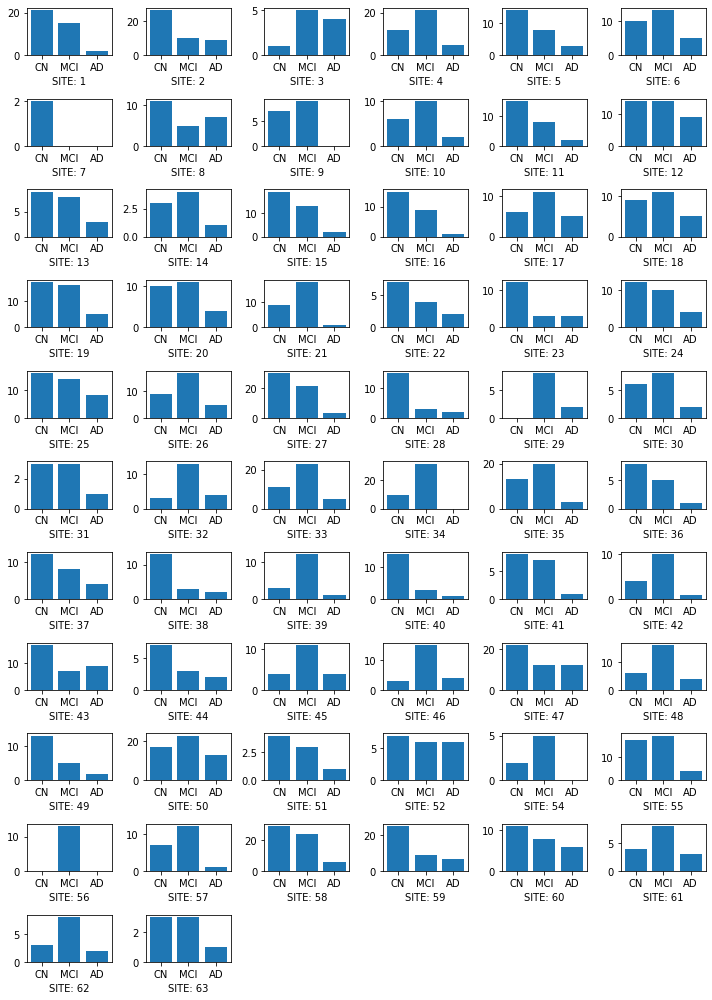

In [3]:
plt.figure(figsize=(10,14))
names = ['CN', 'MCI', 'AD']
sites = set(df_full['SITEID'])
for i, site in enumerate(sites):
    # Explor variability of features by site
    plt.subplot(11,6,i+1)
    df_site = df_full[df_full['SITEID']==site]
    vals = [np.sum(df_site['DIAGNOSIS']==diag) for diag in [1.0, 2.0, 3.0]]
    plt.bar(names, vals)
    plt.xlabel('SITE: %d' %site)
    plt.tight_layout()

The distiribution of subjects in each site is very different. 

### Statistics

In [4]:
# Subject types
print('Initial screening category')
print('CN: %d' % len(df_full[df_full['DIAGNOSIS']==1.0]))
print('MCI: %d' % len(df_full[df_full['DIAGNOSIS']==2.0]))
print('AD: %d' % len(df_full[df_full['DIAGNOSIS']==3.0]))

# Conversor types
print('Conversor category')
print('CN2MCI: %d' % len(df_full[df_full['TYPECONVERSOR']==4.0]))
print('CN2AD: %d' % len(df_full[df_full['TYPECONVERSOR']==6.0]))
print('MCI2AD: %d' % len(df_full[df_full['TYPECONVERSOR']==5.0]))

Initial screening category
CN: 646
MCI: 656
AD: 217
Conversor category
CN2MCI: 65
CN2AD: 7
MCI2AD: 155


### Age distribution

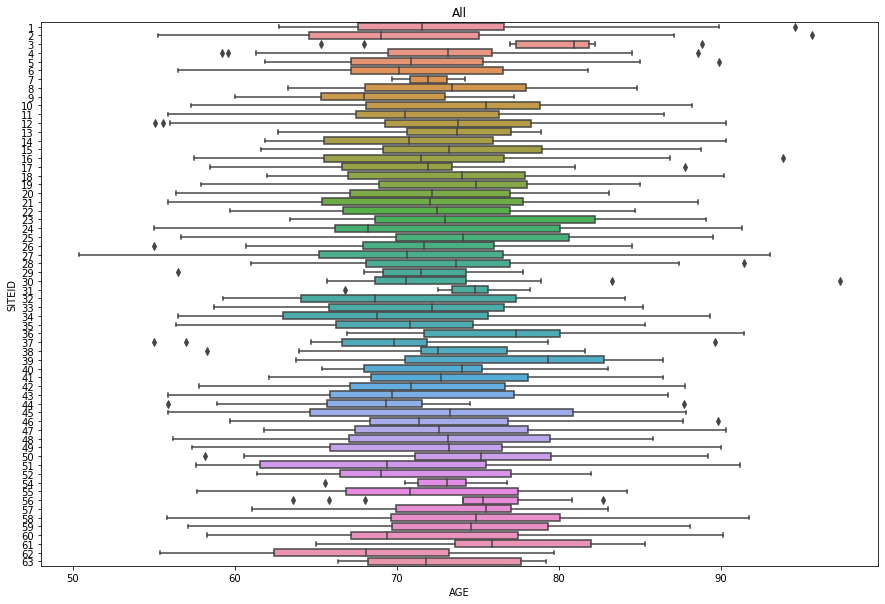

In [5]:
# Show age distribution by site
plt.figure(figsize=(15, 10))
plt.title('All')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full, orient='h')
plt.show()

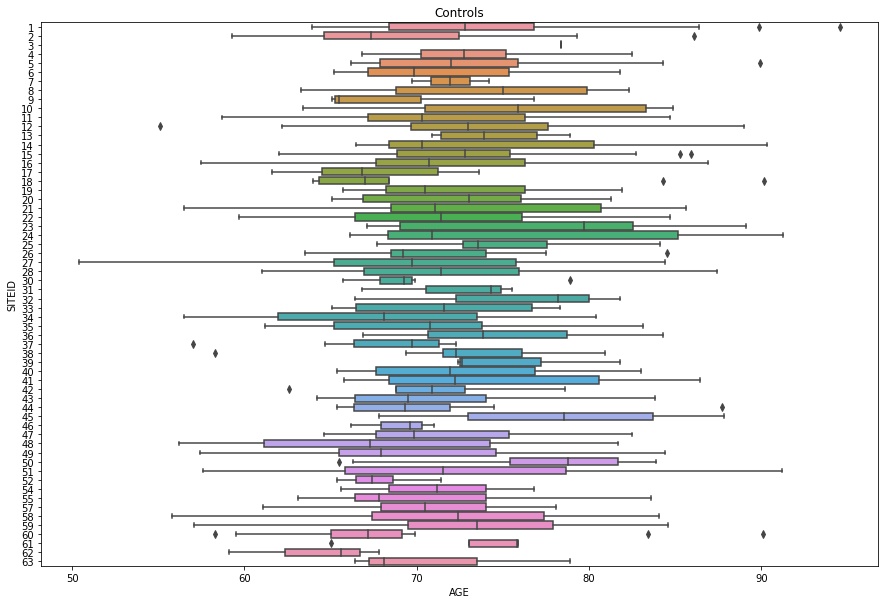

In [6]:
# Show age distribution by site
plt.figure(figsize=(15, 10))
plt.title('Controls')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==1.0], orient='h')
plt.show()

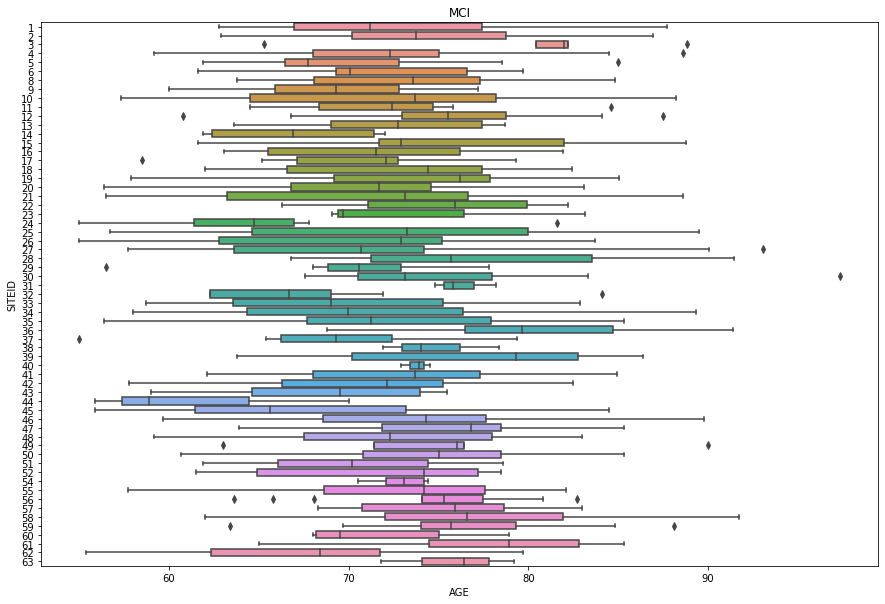

In [7]:
# Show age distribution by site
plt.figure(figsize=(15, 10))
plt.title('MCI')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==2.0], orient='h')
plt.show()

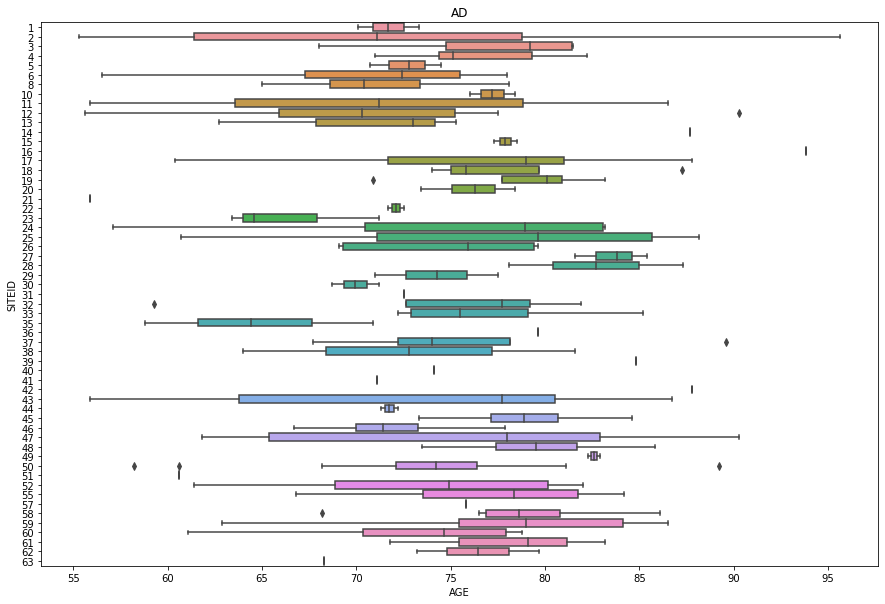

In [8]:
# Show age distribution by site
plt.figure(figsize=(15, 10))
plt.title('AD')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==3.0], orient='h')
plt.show()

The age distributions are different for each site. Hence, most of the variability due to sites will be due to their variability in age, hence even when applying homogenisation technique we do not expect the box plots to align perfectly as our variable of interest is age. However, most importantly is to look at the age distirbutions overall of all the data.

p-value of age distributions
CN vs MCI: 0.118188
CN vs AD: 0.000000
MCI vs AD: 0.000043


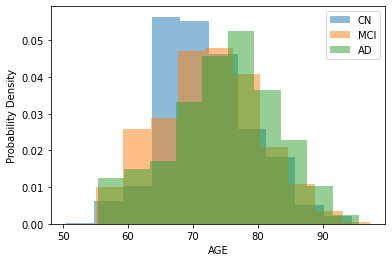

In [9]:
# Check p-values between groups for age
cn_age = df_full[df_full['DIAGNOSIS']==1.0]['AGE'].to_numpy()
mci_age = df_full[df_full['DIAGNOSIS']==2.0]['AGE'].to_numpy()
ad_age = df_full[df_full['DIAGNOSIS']==3.0]['AGE'].to_numpy()

print('p-value of age distributions')
hstat_cnvsmci_age, pval_cnvsmci_age = kruskal(cn_age, mci_age)
hstat_cnvsad_age, pval_cnvsad_age = kruskal(cn_age, ad_age)
hstat_mcivsad_age, pval_mcivsad_age = kruskal(ad_age, mci_age)
print('CN vs MCI: %f' % pval_cnvsmci_age)
print('CN vs AD: %f' % pval_cnvsad_age)
print('MCI vs AD: %f' % pval_mcivsad_age)

plt.hist(cn_age, label='CN', density=True, alpha=0.5)
plt.hist(mci_age, label='MCI', density=True, alpha=0.5)
plt.hist(ad_age, label='AD', density=True, alpha=0.5)
plt.xlabel('AGE')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

CN and MCI distributions are similar but not to AD. Therefore for homgoenisation we will have to subsample CN and MCI groups as they have the highest number of subjects as subsampling AD would leave very few AD subjects.

### Homogenisation

In [10]:
# Process for homogenisation
def process_df_homogenisation(df, min_cn):

    # Remove sites with fewer than min_cn sites
    sites = set(df['SITEID'])
    df_cn = df[df['DIAGNOSIS']==1.0]
    big_sites = [site for site in sites if df_cn['SITEID'].to_list().count(site) > min_cn]
    df = df[df['SITEID'].isin(big_sites)]

    # Remove sites that do not contain AD or MCI patients
    mci_sites = set(df[df['DIAGNOSIS']==2.0]['SITEID'])
    df = df[df['SITEID'].isin(mci_sites)]
    ad_sites = set(df[df['DIAGNOSIS']==3.0]['SITEID'])
    df = df[df['SITEID'].isin(ad_sites)]

    return df

df_homo = process_df_homogenisation(df_full, 10)

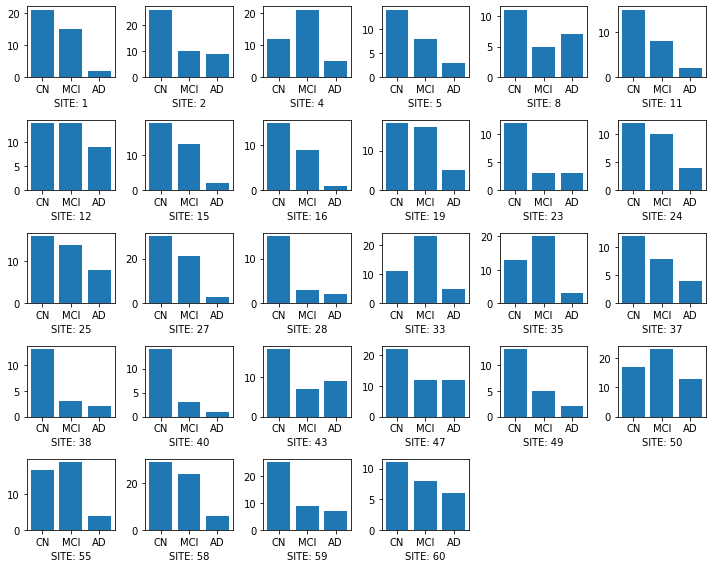

In [11]:
plt.figure(figsize=(10,8))
names = ['CN', 'MCI', 'AD']
sites = set(df_homo['SITEID'])
for i, site in enumerate(sites):
    # Explor variability of features by site
    plt.subplot(5,6,i+1)
    df_site = df_homo[df_homo['SITEID']==site]
    vals = [np.sum(df_site['DIAGNOSIS']==diag) for diag in [1.0, 2.0, 3.0]]
    plt.bar(names, vals)
    plt.xlabel('SITE: %d' %site)
    plt.tight_layout()

p-value of age distributions
CN vs MCI: 0.121479
CN vs AD: 0.000153
MCI vs AD: 0.010328


<function matplotlib.pyplot.legend(*args, **kwargs)>

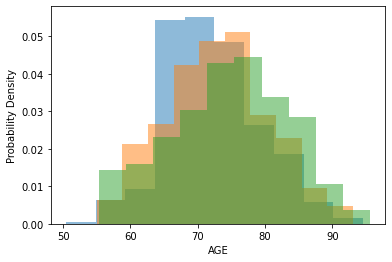

In [12]:
# Check p-values between groups for age
cn_age = df_homo[df_homo['DIAGNOSIS']==1.0]['AGE'].to_numpy()
mci_age = df_homo[df_homo['DIAGNOSIS']==2.0]['AGE'].to_numpy()
ad_age = df_homo[df_homo['DIAGNOSIS']==3.0]['AGE'].to_numpy()

print('p-value of age distributions')
hstat_cnvsmci_age, pval_cnvsmci_age = kruskal(cn_age, mci_age)
hstat_cnvsad_age, pval_cnvsad_age = kruskal(cn_age, ad_age)
hstat_mcivsad_age, pval_mcivsad_age = kruskal(ad_age, mci_age)
print('CN vs MCI: %f' % pval_cnvsmci_age)
print('CN vs AD: %f' % pval_cnvsad_age)
print('MCI vs AD: %f' % pval_mcivsad_age)

plt.hist(cn_age, label='CN', density=True, alpha=0.5)
plt.hist(mci_age, label='MCI', density=True, alpha=0.5)
plt.hist(ad_age, label='AD', density=True, alpha=0.5)
plt.xlabel('AGE')
plt.ylabel('Probability Density')
plt.legend

The age distributions are still very different for each group. Using a subsampling technique based on matching the CN and MCI distiburtion to the AD we can match the distributions.

In [13]:
def optimize_sampling(sampling_strategy, samples, sample_ids, target_dist, thr_pval, **kwargs):
    for sample_size in range(len(samples), 0, -1):
        new_sample_ids = sampling_strategy(samples, sample_ids, sample_size, **kwargs)
        new_samples = [sample for sample, sample_id in zip(samples, sample_ids) if sample_id in new_sample_ids]
        hstat, pval = kruskal(new_samples, target_dist)
        if pval > thr_pval:
            return new_sample_ids
        
def subsampling_matching(samples, sample_ids, sample_size, subsampling_dist, N_BINS):
    # Obtain `N_BINS` equal frequency bins, in other words percentiles
    step = 100 / N_BINS
    test_percentiles = [
        np.percentile(subsampling_dist, q, axis=0)
        for q in np.arange(start=0, stop=100, step=step)
    ]

    # Match each observation in the training set to a bin
    train_bins = np.digitize(samples, test_percentiles)

    # Count the number of values in each training set bin
    train_bin_counts = np.bincount(train_bins)

    # Weight each observation in the training set based on which bin it is in
    weights = 1 / np.array([train_bin_counts[x] for x in train_bins])

    # Make the weights sum up to 1
    weights_norm = weights / np.sum(weights)

    np.random.seed(0)
    new_sample_ids = np.random.choice(sample_ids, size=sample_size, p=weights_norm, replace=False)
    
    return new_sample_ids

CN current size: 463
CN new size: 304
MCI current size: 334
MCI new size: 269


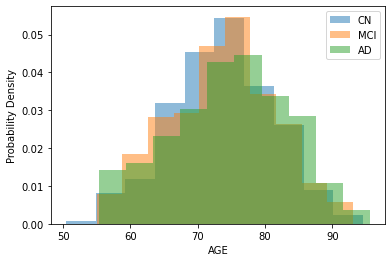

p-value of age distributions
CN vs MCI: 0.933310
CN vs AD: 0.100029
MCI vs AD: 0.108174


In [14]:
# Match distributions of CN and MCI
df_cn = df_homo[df_homo['DIAGNOSIS']==1.0]
cn_rids = df_cn['RID'].tolist()
new_cn_ids = optimize_sampling(subsampling_matching, cn_age, cn_rids, ad_age, 0.1,
                               N_BINS=15, subsampling_dist=ad_age)
df_mci = df_homo[df_homo['DIAGNOSIS']==2.0]
mci_rids = df_mci['RID'].tolist()
new_mci_ids = optimize_sampling(subsampling_matching, mci_age, mci_rids, ad_age, 0.1,
                               N_BINS=15, subsampling_dist=ad_age)

# Show change in sizes
print('CN current size: %d' % len(cn_age))
print('CN new size: %d' % len(new_cn_ids))
new_cn_ages = df_cn[df_cn['RID'].isin(new_cn_ids)]['AGE'].to_numpy()
print('MCI current size: %d' % len(mci_age))
print('MCI new size: %d' % len(new_mci_ids))
new_mci_ages = df_mci[df_mci['RID'].isin(new_mci_ids)]['AGE'].to_numpy()

# Show visual that distributions match
plt.hist(new_cn_ages, label='CN', density=True, alpha=0.5)
plt.hist(new_mci_ages, label='MCI', density=True, alpha=0.5)
plt.hist(ad_age, label='AD', density=True, alpha=0.5)
plt.xlabel('AGE')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# Show p-value of new 
print('p-value of age distributions')
hstat_cnvsmci_age, pval_cnvsmci_age = kruskal(new_cn_ages, new_mci_ages)
hstat_cnvsad_age, pval_cnvsad_age = kruskal(new_cn_ages, ad_age)
hstat_mcivsad_age, pval_mcivsad_age = kruskal(ad_age, new_mci_ages)
print('CN vs MCI: %f' % pval_cnvsmci_age)
print('CN vs AD: %f' % pval_cnvsad_age)
print('MCI vs AD: %f' % pval_mcivsad_age)

In [15]:
# Store csv with rids of all patients left
ad_ids = df_homo[df_homo['DIAGNOSIS']==3.0]['RID'].tolist()
all_ids_remaining = [*new_cn_ids, *new_mci_ids, *ad_ids]
df_homo = df_homo[df_homo['RID'].isin(all_ids_remaining)]
df_homo.to_csv('../DATA/adni_full_data_for_homogenisation.csv')